In [1]:
from Signal_generator.generate_signal import generate_X_matrix
from Algorithmes.beamforming import beamforming_method
from Signal_generator.generate_signal import generate_A_matrix
from Signal_generator.generate_signal import generate_S_matrix
from Signal_generator.generate_signal import generate_noise
from Signal_generator.generate_signal import generate_R_hat
from Signal_generator.generate_signal import generate_R_hat_with_phase
from Algorithmes.music import music_method
from Algorithmes.music import estimate_angles
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 
import numpy as np
import torch
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import itertools
from torchsummary import summary
from numpy.linalg import eigh
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
import math
import random
from sklearn.metrics import mean_squared_error
from Algorithmes.music import generate_steering_vector
from Plots.draw_plot import plot_single_music

In [2]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():  
    torch.cuda.manual_seed_all(42)

In [5]:
import numpy as np

def calculate_music_spectrum(R_hat, nbSensors, nbSources, angles_range):
    # Calculer les vecteurs propres et les valeurs propres
    _, eigenvectors = np.linalg.eigh(R_hat)
    # Sélectionner les k plus grandes valeurs propres
    noise_subspace = eigenvectors[:, :-nbSources]
    music_spectrum = np.zeros_like(angles_range, dtype=float)
    for idx, theta in enumerate(angles_range):
        steering_vector = generate_steering_vector(nbSensors, theta)
        music_spectrum[idx] = 1 / np.linalg.norm(noise_subspace.conj().T @ steering_vector)

    return music_spectrum

perturbation_parameter_sd = 0

In [6]:
import itertools

def generate_combinations(phi_max, rho, nb_sources):
    """Cette fonction sert à générer toutes les combinaisons d'angles possibles dans la plage de résolution"""
    # Générer une plage de valeurs possibles pour les signaux
    values = list(range(-int(phi_max / rho), int(phi_max / rho) + 1))
    
    # Générer toutes les combinaisons possibles de signaux
    all_combinations = list(itertools.product(values, repeat=nb_sources))
    
    # Supprimer les combinaisons où l'ordre ne compte pas et où deux signaux ont la même valeur
    unique_combinations = {tuple(sorted(combination)) for combination in all_combinations if len(set(combination)) == nb_sources}
    
    return list(unique_combinations)

#
Q = 4
N = 2**12
phi_max = 60
rho = 1
nbSources = 2 # Nombre de sources
nbSensors = 9 # Nombre de capteurs
nbTimePoints = 100 # Nombre de points temporels
signal_noise_ratio = 10 # Rapport signal sur bruit en décibels. Si 'False', cela revient à une absence totale de bruit.
theta1 = -20 # Angle entre la perpendiculaire à la ligne de capteurs, et la source 1
theta2 = 20 # Angle entre la perpendiculaire à la ligne de capteurs, et la source 2
var_ratio = [1] # Liste qui donne le rapport entre la variance du signal 1 et celui des autres sources (ex: [2, 3] signifie que la source 2 a une variance 2 fois plus grande que la source 1, et la source 3 a une variance 3 fois plus grande que la source 1)
correlation_List = [0] # Liste des corrélations. Il y a une corrélation nécéssaire pour chaque paire distincte de sources différentes: 0 pour 1 source, 1 pour 2 sources, 3 pour 3 sources, 6 pour 4 sources etc...
# Ordre de remplisage de la correlation_List: de gauche à droite et ligne par ligne, moitié haut-droite de la matrice uniquement, puis symétrie de ces valeurs pour la moitié bas-gauche
perturbation_parameter_sd = 0 # Écart-type de la distribution normale qui génère les erreurs de calibration des capteurs
J_alpha = 100
J_beta = 10

def generate_deepmusic_partitioned_data(J_alpha, J_beta, nbSensors, nbSources, T, SNR_TRAIN, Q, N, phi_max, rho, correlation_List, var_ratio):
    training_data_sets = [[] for _ in range(Q)]
    full_theta = np.linspace(-phi_max, phi_max, N)
    L = N // Q

    for signal_noise_ratio in SNR_TRAIN:
        for j_alpha in range(J_alpha):
            # Générer des angles pour les sources de manière aléatoire dans toutes les sous-régions
            source_angles = []
            subregions_indices = np.random.choice(Q, nbSources, replace=False)
            for q in subregions_indices:
                start_theta = -phi_max + q * (2 * phi_max / Q)
                end_theta = start_theta + (2 * phi_max / Q)
                angle = np.random.uniform(start_theta, end_theta)
                source_angles.append(angle)

            for j_beta in range(J_beta):
                varList = np.ones(nbSources).tolist()
                correlation_List = np.zeros(nbSources * (nbSources - 1) // 2).tolist()
                X = generate_X_matrix(nbSources=nbSources, nbSensors=nbSensors, nbTimePoints=T, thetaList=source_angles, var_ratio=var_ratio, correlation_List=correlation_List, signal_noise_ratio=signal_noise_ratio, perturbation_parameter_sd=0)
                R_hat = generate_R_hat(X)
                R_hat_with_phase = generate_R_hat_with_phase(X)
                
                full_music_spectrum = calculate_music_spectrum(R_hat, nbSensors, nbSources, full_theta)

                for q in range(Q):
                    start_index = q * L
                    end_index = (q + 1) * L if q != Q - 1 else N
                    pq = full_music_spectrum[start_index:end_index]
                    
                    input_data = R_hat_with_phase
                    output_data = pq
                    training_data_sets[q].append((input_data, output_data))

    return training_data_sets

full_theta = np.linspace(- phi_max , phi_max, N)
# Example usage
SNR_TRAIN = [0]  # Different SNR levels for training
training_datasets = generate_deepmusic_partitioned_data(J_alpha=J_alpha,J_beta=J_beta,nbSensors=nbSensors, nbSources=nbSources, T=nbTimePoints, SNR_TRAIN=SNR_TRAIN, Q=Q, N=N, phi_max=phi_max, rho=rho, correlation_List=correlation_List, var_ratio=var_ratio)


In [5]:
subinterval_length = N//Q
thetaList = [np.random.uniform(-phi_max + q * subinterval_length, -phi_max + (q + 1) * subinterval_length) for q in range(nbSources)]
thetaList

[810.1920365724303, 1063.6830735737888]

In [6]:
input_data, output_data = training_datasets[1][978]
a = []
for i in range(0,Q-1):
    input_data, output_data = training_datasets[i][978]
    a.append(output_data)

<class 'list'>


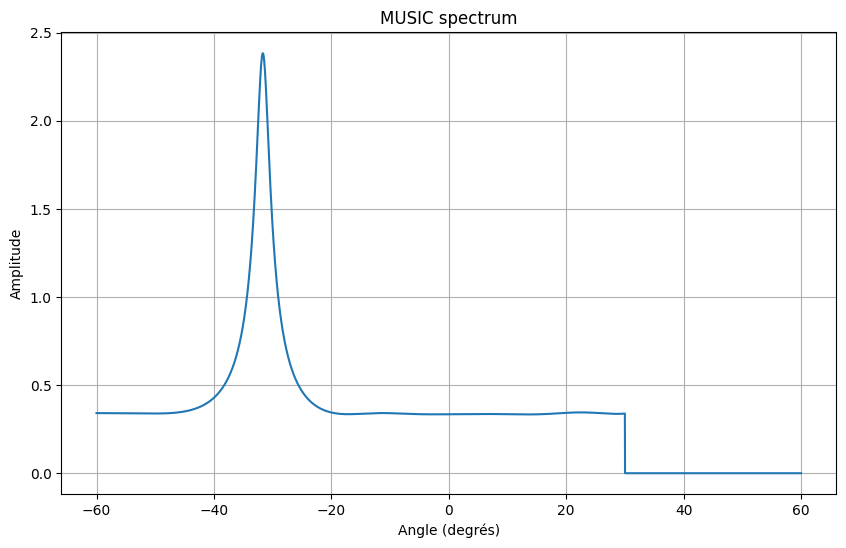

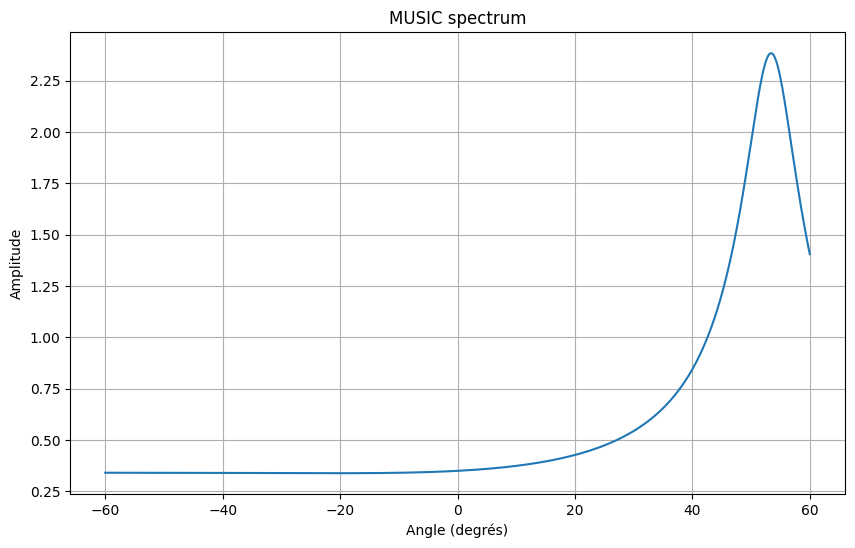

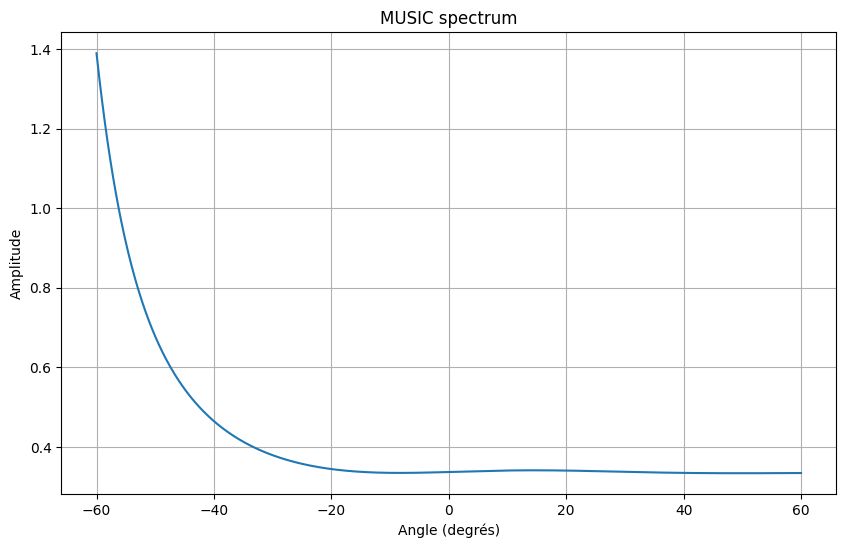

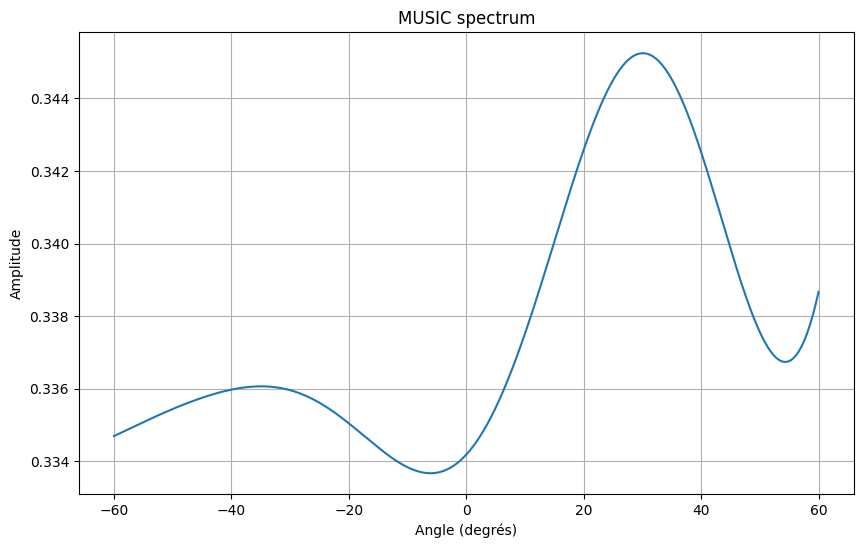

In [25]:
def reconstruct_music_spectrum(segments, Q, N):
    """
    Reconstruct the full music spectrum from its segmented parts.

    Args:
    segments (list of ndarrays): The segmented parts of the music spectrum.
    Q (int): The number of segments.
    N (int): The total number of points in the full music spectrum.

    Returns:
    ndarray: The reconstructed music spectrum.
    """
    # Initialize the reconstructed spectrum with zeros
    reconstructed_spectrum = np.zeros(N, dtype=float)
    
    # Length of each segment
    segment_length = N // Q

    # Iterate over each segment and place it in the reconstructed spectrum
    for q, segment in enumerate(segments):
        start_index = q * segment_length
        if q < Q - 1:
            # For all but the last segment, use the segment length
            end_index = start_index + segment_length
        else:
            # For the last segment, it can be longer if N is not divisible by Q
            end_index = N
        # Make sure segment is the correct shape
        segment = segment[:end_index - start_index]
        reconstructed_spectrum[start_index:end_index] = segment
    
    return reconstructed_spectrum
    

reconstruct_music_spectrum(a, Q, N)
print(type(a))
plot_single_music(reconstruct_music_spectrum(a, Q, N),np.linspace(-60,60,N))
for i in range(0,Q-1):
    input_data, output_data = training_datasets[i][978]
    plot_single_music(output_data,np.linspace(-60,60,N//Q))

In [7]:
def normalize_data(training_data_sets):
    # Calculer la moyenne et l'écart-type pour la normalisation
    all_data = np.concatenate([data[0] for q_data in training_data_sets for data in q_data], axis=0)
    mean = np.mean(all_data, axis=(0, 2), keepdims=True)
    std = np.std(all_data, axis=(0, 2), keepdims=True)

    # Normaliser les données
    normalized_training_data_sets = []
    for q_data in training_data_sets:
        normalized_q_data = []
        for input_data, output_data in q_data:
            normalized_input = (input_data - mean) / std
            normalized_q_data.append((normalized_input, output_data))
        normalized_training_data_sets.append(normalized_q_data)

    return normalized_training_data_sets

# Exemple d'utilisation
normalized_training_datasets = normalize_data(training_datasets)

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class DeepMusicDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_data, output_data = self.data[idx]
        return torch.tensor(input_data, dtype=torch.float32), torch.tensor(output_data, dtype=torch.float32)

def create_loaders_for_subregion(data, batch_size=32, train_size=0.8):
    # Séparation des données en ensembles d'entraînement, de validation et de test
    train_data, test_data = train_test_split(data, train_size=train_size, random_state=42)

    # Création des instances de DeepMusicDataset
    train_dataset = DeepMusicDataset(train_data)
    test_dataset = DeepMusicDataset(test_data)

    # Création des DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, test_loader

# Création des DataLoader pour chaque sous-région
loaders_per_subregion = [create_loaders_for_subregion(normalized_training_datasets[q]) for q in range(Q)]

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepMusicModel(nn.Module):
    def __init__(self, output_size):
        super(DeepMusicModel, self).__init__()
        # Define the first convolutional layer with adjusted stride and padding
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=256)
        
        # Define the second convolutional layer with adjusted stride and padding
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(num_features=256)
        
        # Define the third convolutional layer with adjusted stride and padding
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=256)
        
        # Define the fourth convolutional layer with adjusted stride and padding
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=256)
        
        # Fully connected layer
        self.fc1 = nn.Linear(6400, output_size)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

        # Softmax layer 
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Apply the first convolutional layer and normalization, followed by ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Apply the second convolutional layer and normalization, followed by ReLU
        x = F.relu(self.bn2(self.conv2(x)))
        
        # Apply the third convolutional layer and normalization, followed by ReLU
        x = F.relu(self.bn3(self.conv3(x)))
        
        # Apply the fourth convolutional layer and normalization, followed by ReLU
        x = F.relu(self.bn4(self.conv4(x)))
        
        # Reshape for the fully connected layer
        x = x.view(x.size(0), -1)

        x = self.fc1(x)

        # Apply the dropout layer
        x = self.dropout(x)

        # Apply the softmax layer
        x = self.softmax(x)

        return x


In [10]:
#Définition du device

device = (
    "gpu"
    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cpu device


In [36]:
import torch
import time
import numpy as np
from scipy.signal import find_peaks
import torch.nn.functional as F

def train_and_evaluate_spectrum(loaders_per_subregion, epochs, nbSources, angles_range, peak_tolerance=5):
    models = []
    train_loss_list = []
    val_loss_list = []
    val_mse_list = []
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'val_mse': [],
        'avg_mse_per_epoch_val': [],
        'avg_mse_per_epoch_train': [],
        'total_mse': None,
        'training_time': None
    }

    # Training configuration
    initial_lr = 0.01
    lr_decay_factor = 0.5
    lr_decay_epoch = 10
    early_stopping_patience = 3

    start_time = time.time()  # Start time for training
    for train_loader, val_loader in loaders_per_subregion:
        model = DeepMusicModel(N//Q)
        optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
        criterion = torch.nn.MSELoss()

        best_val_mse = float('inf')
        epochs_no_improve = 0

        for epoch in range(epochs):
            # Adjust learning rate
            if epoch % lr_decay_epoch == 0 and epoch > 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= lr_decay_factor

            # Training loop
            model.train()
            train_loss = 0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets).item()
                optimizer.step()
                train_loss += loss
                
            avg_train_loss = train_loss / len(train_loader)
            train_loss_list.append(avg_train_loss)
            metrics["train_loss"].append(avg_train_loss)
            # Validation loop
            model.eval()
            val_loss, val_mse = 0, 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    val_loss += criterion(outputs, targets).item()
                    val_mse += F.mse_loss(outputs, targets).item()

            avg_val_loss = val_loss / len(val_loader)
            avg_val_mse = val_mse / len(val_loader)
            val_loss_list.append(avg_val_loss)
            metrics["val_loss"].append(avg_val_loss)
            val_mse_list.append(avg_val_mse)
            metrics["val_mse"].append(avg_val_mse)

            # Early stopping
            if avg_val_mse < best_val_mse:
                best_val_mse = avg_val_mse
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve == early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        models.append(model)

    # Calculate training time
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time} seconds")

    # Calculate the average MSE per epoch on the validation set
    avg_mse_per_epoch_val = []
    for epoch in range(epochs):
        epoch_mse = []
        for i, model in enumerate(models):
            # Determine the actual number of epochs the model was trained for
            actual_epochs = len(train_loss_list[i * epochs:(i + 1) * epochs])
            if epoch < actual_epochs:
                epoch_mse.append(train_loss_list[i * epochs + epoch])
        avg_mse_per_epoch_val.append(np.mean(epoch_mse))
        metrics["avg_mse_per_epoch_train"].append(np.mean(epoch_mse))

    print("Average MSE per epoch on validation set:", avg_mse_per_epoch_val)

    # Calculate the average MSE per epoch on the training set
    avg_mse_per_epoch_train = []
    for epoch in range(epochs):
        epoch_mse = []
        for i, model in enumerate(models):
            # Determine the actual number of epochs the model was trained for
            actual_epochs = len(val_mse_list[i * epochs:(i + 1) * epochs])
            if epoch < actual_epochs:
                epoch_mse.append(val_mse_list[i * epochs + epoch])
        avg_mse_per_epoch_train.append(np.mean(epoch_mse))
        metrics["avg_mse_per_epoch_train"].append(np.mean(epoch_mse))

    print("Average MSE per epoch on training set:", avg_mse_per_epoch_train)
    metrics['training_time'] = training_time
    print(f'Average Training Loss: {np.mean(train_loss_list):.4f}')
    print(f'Average Validation Loss: {np.mean(val_loss_list):.4f}')
    print(f'Training time: {training_time}')
    return models, metrics
# Example usage
model1_results = train_and_evaluate_spectrum(loaders_per_subregion=loaders_per_subregion, epochs=10, nbSources=nbSources, angles_range=full_theta, peak_tolerance=5)

Early stopping at epoch 4
Early stopping at epoch 4
Early stopping at epoch 7
Early stopping at epoch 9
Training time: 18.08785605430603 seconds
Average MSE per epoch on validation set: [0.49685681581497193, 0.49685760656992595, 0.49685651222864785, 0.4968568893273672, 0.41226009249687195, 0.4687763231992721, 0.4687756299972534, 0.46877622783184053, 0.4701670104265213, 0.4701677197217941]
Average MSE per epoch on training set: [0.4843848264879651, 0.48438490761650926, 0.4843849572870466, 0.4843849473529392, 0.42175810287396115, 0.47497858852148056, 0.47497785091400146, 0.4749777515729269, 0.46571960796912515, 0.46571914106607437]
Average Training Loss: 0.4783
Average Validation Loss: 0.4737
Training time: 18.08785605430603


In [37]:
from Models.compare import *
models, _ = model1_results
save_models_hyperparams_and_metadata(models, hyperparameters_list=[{"A" : "a"} for _ in range(Q)], metadata_list=[{"A" : "a"} for _ in range(Q)], directory_name="DeepMusic_subregion")

In [16]:
models

[DeepMusicModel(
   (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv2): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (fc1): Linear(in_features=20736, out_features=1024, bias=True)
   (dropout): Dropout(p=0.5, inplace=False)
   (softmax): Softmax(dim=1)
 ),
 DeepMusicModel(
   (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

In [25]:
from sklearn.model_selection import KFold
import time
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

def train_and_evaluate_spectrum_with_cv(data_loaders, epochs, nbSources, angles_range, k_folds=5):
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'val_mse': [],
        'total_mse': [],
        'training_time': []
    }
    initial_lr = 0.1
    lr_decay_factor = 0.5
    lr_decay_epoch = 10
    early_stopping_patience = 3

    kf = KFold(n_splits=k_folds, shuffle=True)

    for fold, (train_idx, val_idx) in enumerate(kf.split(data_loaders[0].dataset)):
        print(f"Fold {fold+1}: Train indices - {train_idx}, Val indices - {val_idx}")  # Affiche les indices utilisés pour le pliage
        print(f"Dataset size: {len(data_loaders[0].dataset)}")  # Affiche la taille du dataset

        train_loader = DataLoader(Subset(data_loaders[0].dataset, train_idx), batch_size=32, shuffle=True)
        val_loader = DataLoader(Subset(data_loaders[1].dataset, val_idx), batch_size=32, shuffle=False)

        model = DeepMusicModel(N // Q)  # Assurez-vous que N et Q sont définis correctement
        optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
        criterion = torch.nn.MSELoss()

        best_val_mse = float('inf')
        start_time = time.time()

        for epoch in range(epochs):
            if epoch % lr_decay_epoch == 0 and epoch > 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= lr_decay_factor

            model.train()
            total_train_loss = 0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            metrics["train_loss"].append(avg_train_loss)

            model.eval()
            total_val_loss, total_val_mse = 0, 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model(inputs)
                    total_val_loss += criterion(outputs, targets).item()
                    total_val_mse += F.mse_loss(outputs, targets).item()

            avg_val_loss = total_val_loss / len(val_loader)
            avg_val_mse = total_val_mse / len(val_loader)
            metrics["val_loss"].append(avg_val_loss)
            metrics["val_mse"].append(avg_val_mse)

            if avg_val_mse < best_val_mse:
                best_val_mse = avg_val_mse
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve == early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1} in fold {fold+1}")
                    break

        end_time = time.time()
        training_time = end_time - start_time
        metrics['training_time'].append(training_time)
        print(f"Fold {fold+1} - Training time: {training_time} seconds")

    return model, metrics

# Utilisation de la fonction
models = []
for data_loaders in loaders_per_subregion:
    model, _ = train_and_evaluate_spectrum_with_cv(data_loaders, 10, nbSources, np.linspace(-60,60,N//Q), k_folds=4)
    models.append(model)

Fold 1: Train indices - [  0   1   3   5   6   7   9  10  11  12  14  17  18  19  20  21  22  23
  24  25  26  27  28  29  30  31  33  34  35  36  38  40  41  42  43  44
  45  46  48  49  50  51  52  53  55  56  57  58  61  62  63  64  65  66
  67  71  73  75  76  77  78  79  81  83  84  85  87  88  89  90  91  92
  93  94  95  98  99 101 102 104 105 107 108 110 111 112 113 116 117 118
 119 122 123 125 126 127 128 129 131 132 133 134 135 137 138 140 142 145
 147 148 149 152 153 154 156 157 158 159 160 161 162 163 165 166 167 168
 169 171 173 174 175 177 178 179 180 181 182 183 184 187 188 189 190 191
 192 193 194 196 198 199 200 201 202 203 204 205 206 209 210 211 212 213
 216 218 220 221 222 224 225 226 227 231 233 234 236 239 241 242 243 244
 247 248 249 250 252 253 254 256 258 259 260 261 263 265 266 267 269 270
 271 273 274 275 276 277 278 279 280 282 284 285 286 287 288 289 290 291
 292 293 294 295 296 297 298 300 301 302 303 304 305 306 307 308 310 311
 312 313 314 315 316 318 31

IndexError: list index out of range

+-